In [18]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load all data
pop_df = pd.read_csv("eth_admpop_adm1_2022_v2.csv")
primary_df = pd.read_csv("ethiopia_education_data_Primary.csv")
secondary_df = pd.read_csv("ethiopia_education_data_Secondary.csv")

# ----------------------------
# Clean Education Data
# ----------------------------
def clean_education_data(df, level):
    df = df.copy()
    df.columns = df.columns.str.strip()
    df['region'] = df['region'].str.strip()
    total_cols = [col for col in df.columns if 'Total' in col]
    df[total_cols] = df[total_cols].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
    df['Education_Level'] = level
    return df[['region'] + total_cols]

primary_clean = clean_education_data(primary_df, 'Primary')
secondary_clean = clean_education_data(secondary_df, 'Secondary')

# Rename for clarity
primary_clean = primary_clean.rename(columns={"2022/23 Total": "Total_primary"})
secondary_clean = secondary_clean.rename(columns={"2022/23 Total": "Total_secondary"})

# Merge primary and secondary
edu_df = pd.merge(primary_clean, secondary_clean, on="region")

# Compute total enrolled
edu_df['Total_enrolled'] = edu_df['Total_primary'] + edu_df['Total_secondary']

# ----------------------------
# Clean Population Data
# ----------------------------
pop_df['region'] = pop_df['admin1Name_en'].str.strip()
pop_df['P_eligible'] = pop_df['T_05_09'] + pop_df['T_10_14']
pop_df['S_eligible'] = pop_df['T_15_19']
pop_df['Eligible_population'] = pop_df['P_eligible'] + pop_df['S_eligible']

pop_clean = pop_df[['region', 'P_eligible', 'S_eligible', 'Eligible_population']]

# ----------------------------
# Merge All
# ----------------------------
final_df = pd.merge(edu_df, pop_clean, on="region", how="left")

# ----------------------------
# Feature Engineering
# ----------------------------
final_df['Literacy_percent'] = (final_df['Total_enrolled'] / final_df['Eligible_population']) * 100

# Optional: save for future use
final_df.to_csv("final_literacy_dataset.csv", index=False)


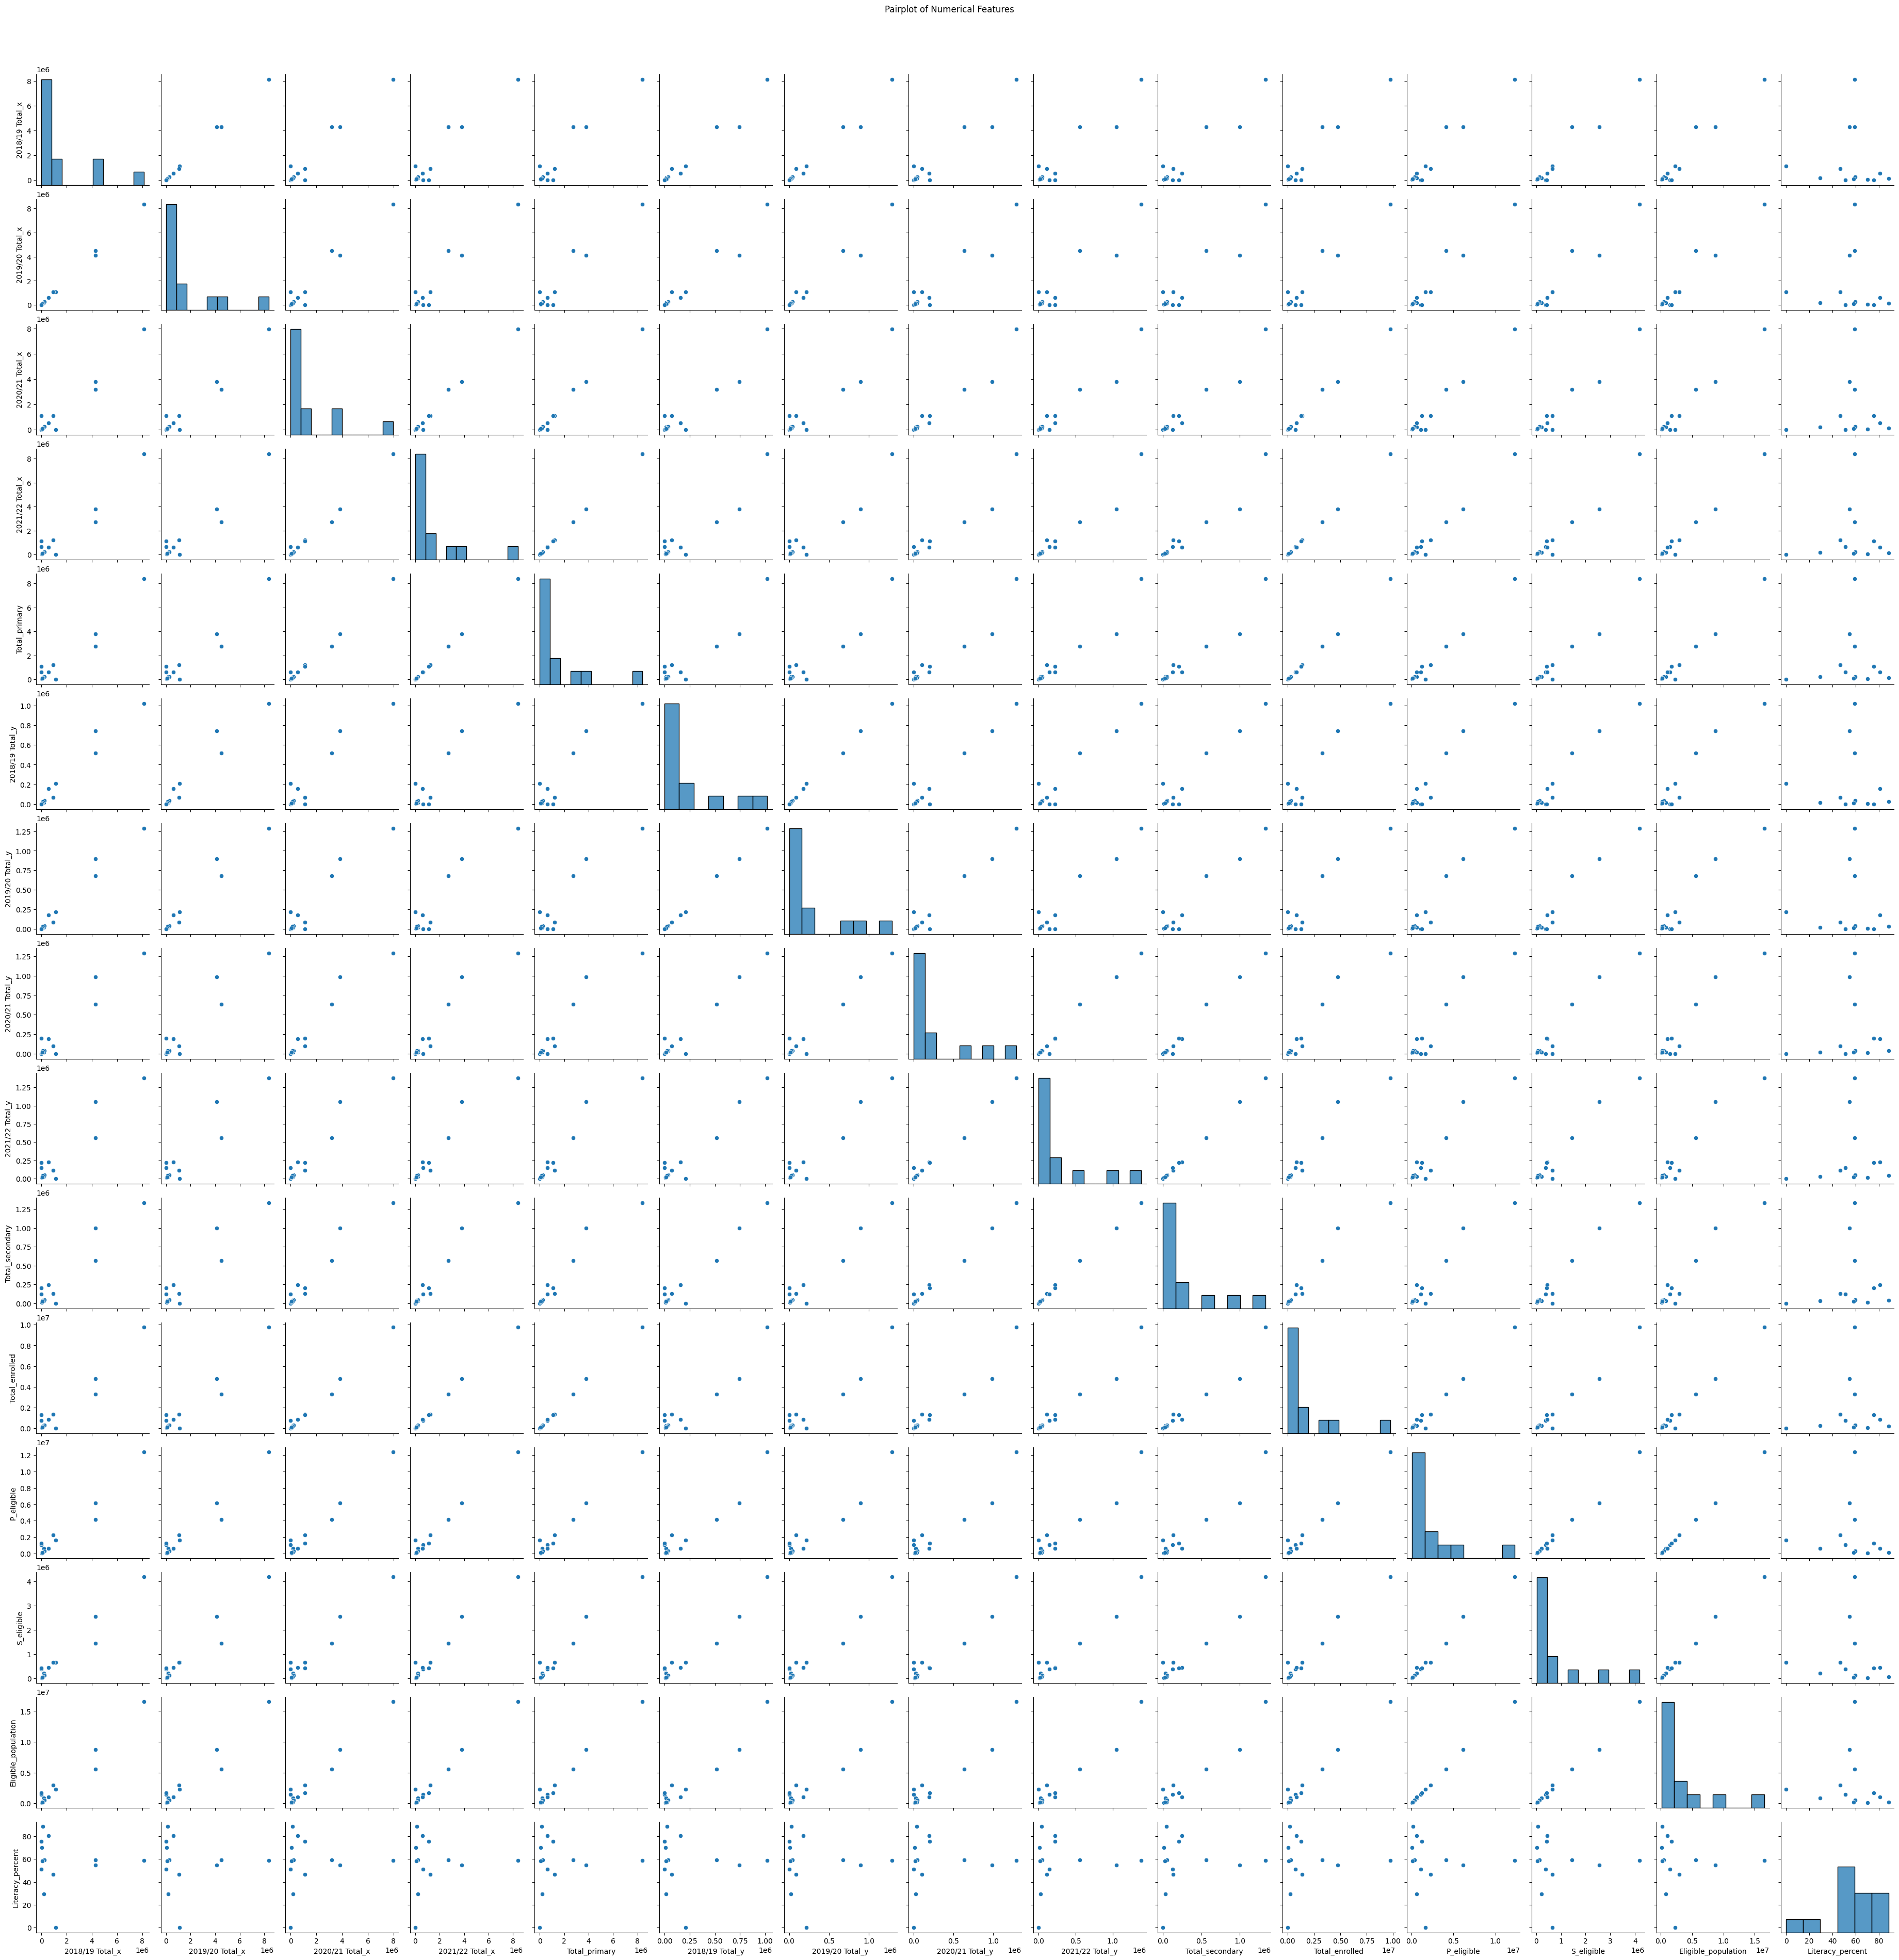

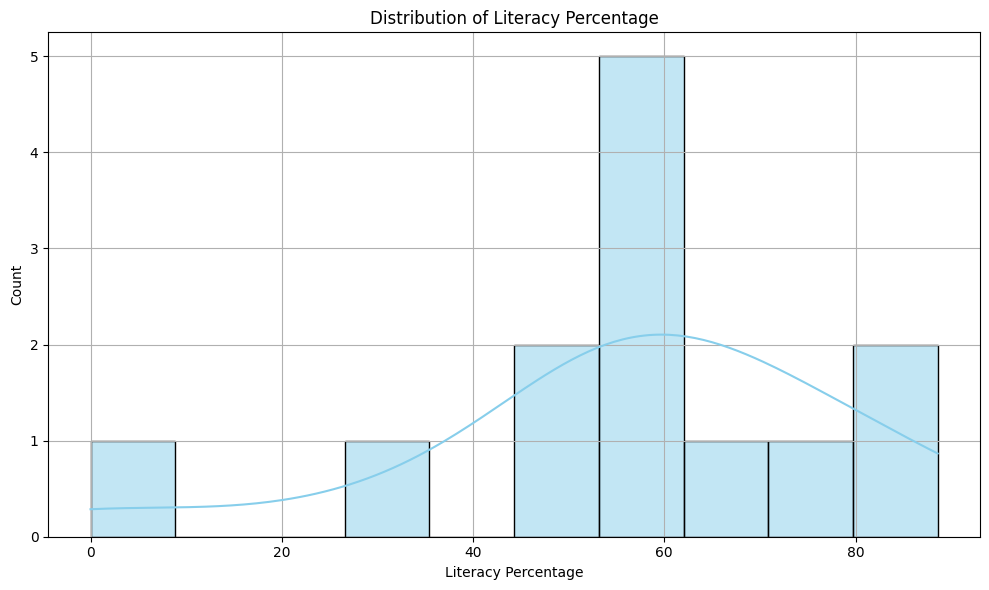

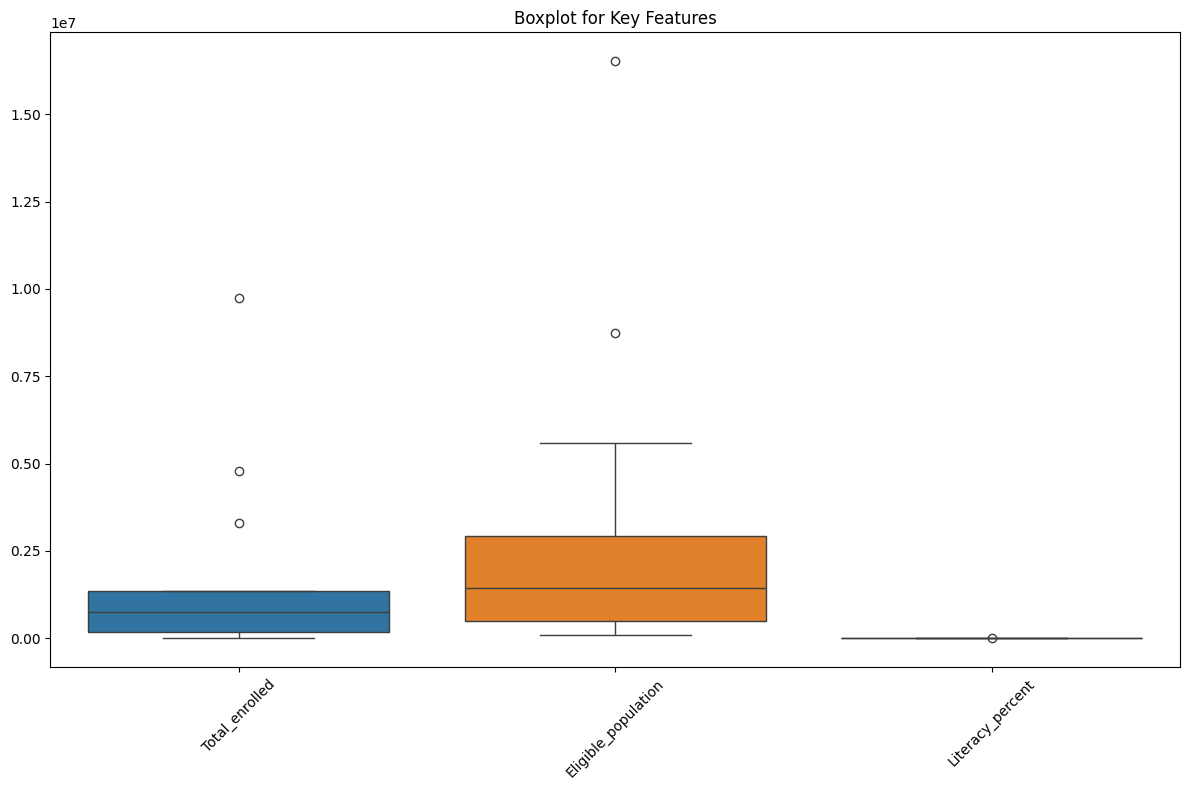

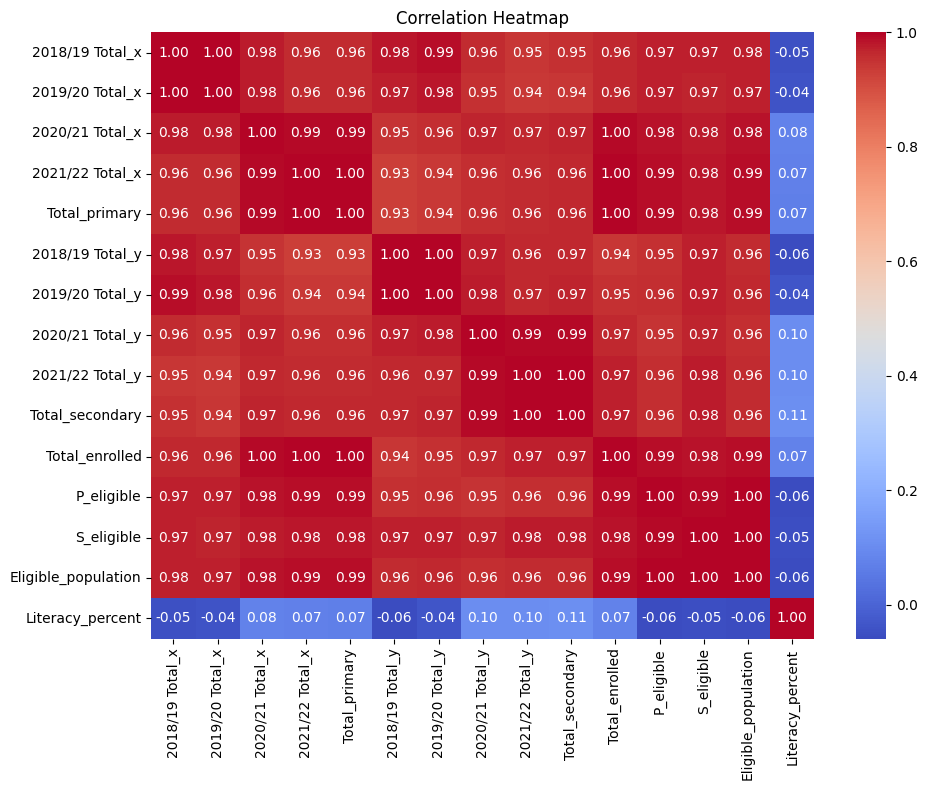

In [2]:
# Pairplot
sns.pairplot(final_df.select_dtypes(include='number'))
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

# Histogram of Literacy Percent
plt.figure(figsize=(10, 6))
sns.histplot(final_df['Literacy_percent'], kde=True, bins=10, color='skyblue')
plt.title("Distribution of Literacy Percentage")
plt.xlabel("Literacy Percentage")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot for Outlier Detection
plt.figure(figsize=(12, 8))
sns.boxplot(data=final_df[['Total_enrolled', 'Eligible_population', 'Literacy_percent']])
plt.title("Boxplot for Key Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(final_df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [3]:
final_df

,region,2018/19 Total_x,2019/20 Total_x,2020/21 Total_x,2021/22 Total_x,Total_primary,2018/19 Total_y,2019/20 Total_y,2020/21 Total_y,2021/22 Total_y,Total_secondary,Total_enrolled,P_eligible,S_eligible,Eligible_population,Literacy_percent
0,Tigray,1133838,1093565,0,0,0,209405,217197,0,0,0,0,1647159,656076,2303235,0.000000
1,Afar,184169,179231,193061,198959,208004,15654,20223,22398,27730,31666,239670,611535,209462,820997,29.192555
2,Amhara,4292424,4106009,3817016,3796673,3781487,743753,894355,982847,1053116,998768,4780255,6172763,2553372,8726135,54.780897
3,Oromia,8140833,8356150,7978121,8404818,8407777,1020127,1289027,1290792,1383558,1335976,9743753,12335742,4181816,16517558,58.990276
4,Somali,933559,1065934,1093654,1225266,1226991,70853,88619,102341,116520,132317,1359308,2256020,659338,2915358,46.625766
5,Benishangul-Gumz,252619,248070,233942,233173,237778,37515,41699,42958,49555,49718,287496,348238,135718,483956,59.405400
6,SNNP,4293712,4515880,3197903,2709156,2739221,517543,678938,637318,560444,564145,3303366,4137646,1445838,5583484,59.163168
7,South West Ethiopia,0,0,0,644644,620815,0,0,0,147161,125410,746225,1078374,376821,1455195,51.280069
8,Gambella,119032,128092,134759,134368,139617,25694,31038,36946,43536,43182,182799,145594,60753,206347,88.588155
9,Harari,51345,55589,54058,57054,58276,8154,8969,11201,13507,13594,71870,74189,28361,102550,70.082886


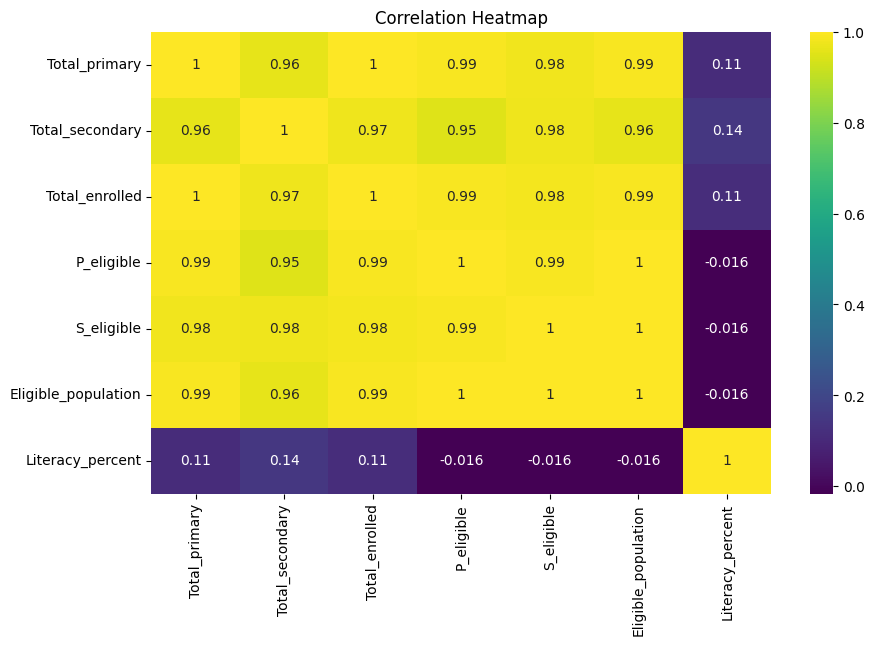

MAE: 32.13
RMSE: 43.84
R² Score: 0.12


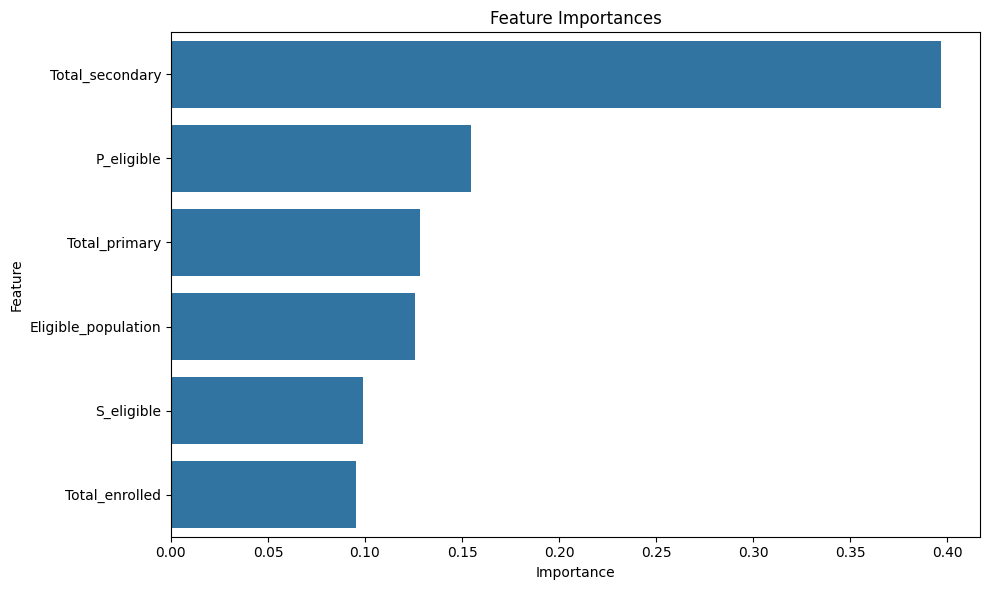

               Feature  Importance
1      Total_secondary    0.397005
3           P_eligible    0.154392
0        Total_primary    0.128239
5  Eligible_population    0.125987
4           S_eligible    0.099120
2       Total_enrolled    0.095257


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load data
primary = pd.read_csv("ethiopia_education_data_Primary.csv")
secondary = pd.read_csv("ethiopia_education_data_Secondary.csv")
population = pd.read_csv("eth_admpop_adm1_2022_v2.csv")

# 2. Rename region columns for consistency
primary = primary.rename(columns={'region': 'Region_name'})
secondary = secondary.rename(columns={'region': 'Region_name'})
population = population.rename(columns={'admin1Name_en': 'Region_name'})

# 3. Extract relevant columns
primary['Total_primary'] = primary['2022/23 Total']
secondary['Total_secondary'] = secondary['2022/23 Total']

# 4. Estimate eligible population
population['P_eligible'] = population['T_07_09'] + population['T_10_14'] if 'T_07_09' in population.columns else population['T_05_09']
population['S_eligible'] = population['T_15_19']

# 5. Create simplified population dataframe
population_data = population[['Region_name', 'P_eligible', 'S_eligible']]

# 6. Merge datasets
merged = pd.merge(primary[['Region_name', 'Total_primary']], 
                  secondary[['Region_name', 'Total_secondary']], 
                  on='Region_name')
merged = pd.merge(merged, population_data, on='Region_name')

# 7. Feature engineering
merged['Total_enrolled'] = merged['Total_primary'] + merged['Total_secondary']
merged['Eligible_population'] = merged['P_eligible'] + merged['S_eligible']
merged['Literacy_percent'] = (merged['Total_enrolled'] / merged['Eligible_population']) * 100

# 8. Clean data
final_df = merged.dropna()

# 9. Correlation heatmap
plt.figure(figsize=(10, 6))
corr_matrix = final_df[['Total_primary', 'Total_secondary', 'Total_enrolled', 
                        'P_eligible', 'S_eligible', 'Eligible_population', 
                        'Literacy_percent']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()

# 10. Model training
X = final_df[['Total_primary', 'Total_secondary', 'Total_enrolled', 
              'P_eligible', 'S_eligible', 'Eligible_population']]
y = final_df['Literacy_percent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 11. Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 12. Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# 13. Feature importance
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# 14. Display feature importance table
print(feat_imp_df)


# 📊 Literacy Analysis Modeling

## 🔧 Data Preparation / Feature Engineering

### 1. Overview
For our Ethiopian literacy rate analysis in the machine learning, we combined enrollment data from the Ministry of Education (MOE) of Ethiopia and eligible population data from HDX (Humanitarian Data Exchange). The goal is to predict literacy rates and understand the gap of education in Ethiopia to address SDG 4. This phase ensures consistency, enhances signal quality, and allows the model to learn meaningful patterns related to literacy rates across regions.


### 2. Data Collection
**Sources**:
- **Education Data (Primary & Secondary)**: Extracted from Ministry of Education (MoE) PDFs, providing regional student enrollment and school counts over multiple academic years.
- **Population Data**: `eth_admpop_adm1_2022_v2.csv` from HDX, offering regional demographic breakdowns (by age/sex).

**Preprocessing**:
- Converted extracted tables to CSV.
- Cleaned numerical fields (e.g., removing commas from enrollment numbers).
- Merged data by administrative region (`region` / `admin1Name_en`).


In [ ]:
import pandas as pd

# Load the datasets
primary_df = pd.read_csv("ethiopia_education_data_Primary.csv")
secondary_df = pd.read_csv("ethiopia_education_data_Secondary.csv")
pop_df = pd.read_csv("eth_admpop_adm1_2022_v2.csv")

# Clean numeric columns (remove commas and convert to int)
for df in [primary_df, secondary_df]:
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'region':
            df[col] = df[col].str.replace(',', '').replace('', '0').astype(int)

primary_df.head()


### 3. Data Cleaning
- Removed commas from numbers and converted to integers.
- Replaced missing values with zero or regional averages where needed.
- Verified consistency in region names and removed rows with complete data absence (e.g., Tigray during conflicts).


### 4. Exploratory Data Analysis (EDA)
Below is a comparison of national total enrollment in primary vs. secondary education from 2018 to 2023.


In [ ]:
import matplotlib.pyplot as plt

years = ['2018/19 Total', '2019/20 Total', '2020/21 Total', '2021/22 Total', '2022/23 Total']

primary_totals = primary_df[years].sum()
secondary_totals = secondary_df[years].sum()

plt.figure(figsize=(10, 6))
plt.plot(years, primary_totals, label='Primary', marker='o')
plt.plot(years, secondary_totals, label='Secondary', marker='o')
plt.title('National Enrollment Trends (Primary vs Secondary)')
plt.xlabel('Academic Year')
plt.ylabel('Total Enrollment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5. Feature Engineering
New features include:
- **Gross Enrollment Ratio** = `Total Enrollment / Age-Eligible Population`
- **School Density** = `Number of Schools / Total Enrollment`
- **Gender Parity Index** = `Female Enrollment / Male Enrollment`

These metrics are strong proxies for literacy rates across regions.


### 6. Data Transformation
- **Normalization**: Scaled features like enrollment ratio and density using Min-Max Scaling.
- **Encoding**: Ensured consistency in region names for merging.
- **Imputation**: Filled gaps using regional averages where appropriate.


### Model Exploration

### 1. Model Selection and Model Training
We trained two models:
- **Random Forest Regressor**: Robust to overfitting, handles non-linear relationships well.
- **Linear Regression**: Simple, interpretable baseline model.

**Training Details**:
- Dataset split: 80% training, 20% testing
- Normalized features
- Hyperparameters: default for both models (no manual tuning)
- No cross-validation applied in this basic version (could be added for robustness)


### 2. Model Evaluation
We used the following metrics to assess model performance:
- **R² Score**: Indicates the proportion of variance explained by the model.
- **MAE (Mean Absolute Error)**: Average magnitude of error.
- **RMSE (Root Mean Squared Error)**: Penalizes larger errors more.

Below is the evaluation output and feature importance visualization from the Random Forest model.


### 3. Code Implementation

Below are the key code snippets for the entire pipeline, including:
- Data loading and cleaning
- Feature engineering
- Model training and evaluation

Additional visualizations include enrollment trends and feature importance.
